In [8]:
import numpy as np
from matplotlib import pyplot as plt

import sys
from pathlib import Path
current_path = Path.cwd()
target_path = current_path.parents[0] 
sys.path.insert(0, str(target_path))

print(target_path)
from plot_parameters import *

from core_equations import calculate_responsivity

c:\Users\nicol\Documents\00Research\PythonCode\ReadoutDesigner


How loop gain and time constants affect responsivity


In [9]:
# constants
V_bias = 1

# initialize arrays to store data
loop_gains = np.linspace(1, 12, 20)
S_Is = np.zeros(len(loop_gains))
S_Is_slow = np.zeros(len(loop_gains))

tau = None
omega = None

# What if detectors are slow?
tau_0 = 30e-3 # s
omega = 8 * 2 * np.pi # Hz


for l, lg in enumerate(loop_gains):
    # calculate tau
    tau = tau_0 / (lg+1)
    # calculate responsitivy for fast detector
    S_Is[l] = calculate_responsivity(V_bias, lg, tau=None, omega=None)
    # calculate responsitivy for slow detector
    S_Is_slow[l] = calculate_responsivity(V_bias, lg, tau, omega)
    


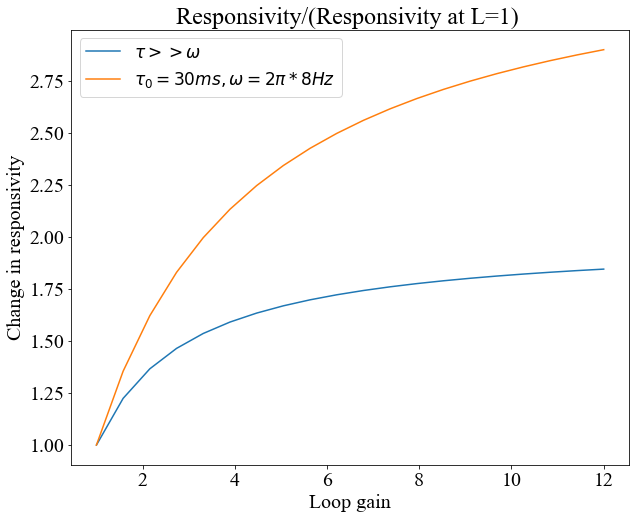

In [10]:
plt.figure(1, figsize=FIG_SIZE)
plt.plot(loop_gains, S_Is/S_Is[0], label = '$\\tau >> \\omega $')
plt.plot(loop_gains, S_Is_slow/S_Is_slow[0], label='$\\tau_0 = {:.0f} ms, \\omega = 2 \\pi * {:.0f} Hz $'.format(tau_0*1000, omega/(2*np.pi)))
plt.xlabel("Loop gain")
plt.ylabel("Change in responsivity")
plt.title("Responsivity/(Responsivity at L=1) ")
plt.legend()

### How stray impedances affect responsivity


In [11]:
def get_loop_gain_factor(R_TES, R_s):
    """Function to see by how much the loop gain changes in comparison to an ideal loop gain
    following equation 12 in LiteBIRD note 74
    returns L_real / L_ideal
    """
    loop_gain_factor = (2*(R_TES**2) / ( (np.abs(R_TES + R_s)) **3) - R_TES/( np.abs(R_TES+R_s)**2) ) * R_TES 
    
    # print("\nRs: ", R_s)
    # print("np.abs(R_TES+R_s)", np.abs(R_TES+R_s))
    # print("loop gain factor", loop_gain_factor)
    
    return loop_gain_factor

def S_I_note_74(loop_gain_real, R_TES, R_s, V_TES):
    """Function to calculate responsivity following equation 13 of LiteBIRD note 74

    Args:
        loop_gain_real (_type_): _description_
        R_TES (_type_): _description_
        R_s (_type_): _description_
    """
    
    #print((1 + (2*np.abs(R_s))/(2*R_TES - np.abs(R_TES + R_s))))
    
    S_I = np.abs( np.sqrt(2)/V_TES * (loop_gain_real/(loop_gain_real+1)) * \
            (1 + (2*np.conj(R_s))/(2*R_TES - np.abs(R_TES + R_s))) )
    
    return S_I
    

In [12]:
for i in range(0,1):
    # constants
    V_TES = 1 # I won't dial this knob 
    R_TES = 1 * 0.7

    # initialize arrays to store data
    loop_gains = np.linspace(1, 20, 21)
    R_s_array = np.linspace(0, R_TES/2, 20)

    # things we'll evaluate
    S_Is = np.zeros( (len(loop_gains), len(R_s_array)))
    boosts = np.zeros( (len(loop_gains), len(R_s_array))) # SI_boosted/SI_not_boosted
    boosts_real = np.zeros( (len(loop_gains), len(R_s_array))) # SI_boosted/SI_not_boosted
    loop_gains_real = np.zeros( (len(loop_gains), len(R_s_array)))
    S_Is_real = np.zeros( (len(loop_gains), len(R_s_array))) # "realistic" , accounting R_s in boost and change in L

    for l, loop_gain in enumerate(loop_gains):
        
        for rs, R_s in enumerate(R_s_array):
            # adjust Vbias so that V_TES is always the same (should be since V_TES is set by P_OPT)
            V_bias = V_TES *  ( R_TES / (R_TES + R_s) ) **(-1)
            
            # calculate responsitivies assuming a fast detector
            # ideal
            #S_I = calculate_responsivity(V_TES, loop_gain, tau=None, omega=None)  
            S_I = S_I_note_74(loop_gain, R_TES, 0, V_TES)
            
            # boosted but with realistic loop gain
            # following equation in LiteBIRD note 74, see what the impact of R_s is on the loopgain
            loop_gain_factor = get_loop_gain_factor(R_TES, R_s)
            loop_gain_real = loop_gain * loop_gain_factor
            # if l==len(loop_gains):
            #     loop_gain_degradations[rs] = lg_real #*100 # in percent
            #S_I_real = calculate_responsivity(V_bias, loop_gain_real, tau=None, omega=None, R_TES=R_TES, R_s = R_s)
            
            S_I_real = S_I_note_74(loop_gain_real, R_TES, R_s, V_TES)
            
            boosts_real[l, rs] = (S_I_real-S_I)/S_I * 100
            
            # store
            S_Is[l, rs] = S_I
            S_Is_real[l, rs] = S_I_real
            loop_gains_real[l, rs] = loop_gain_real    

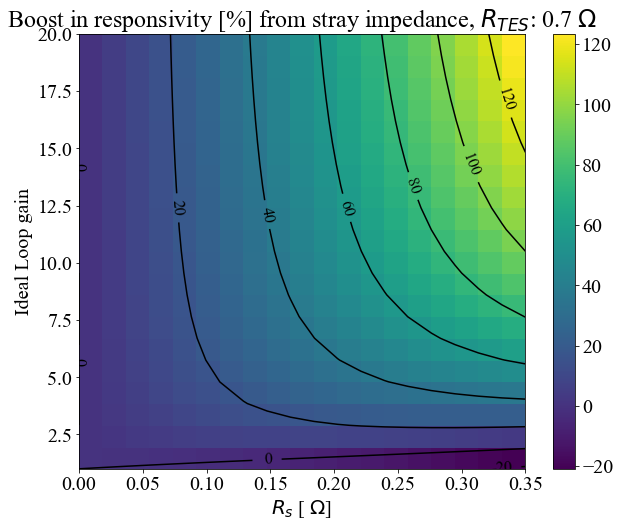

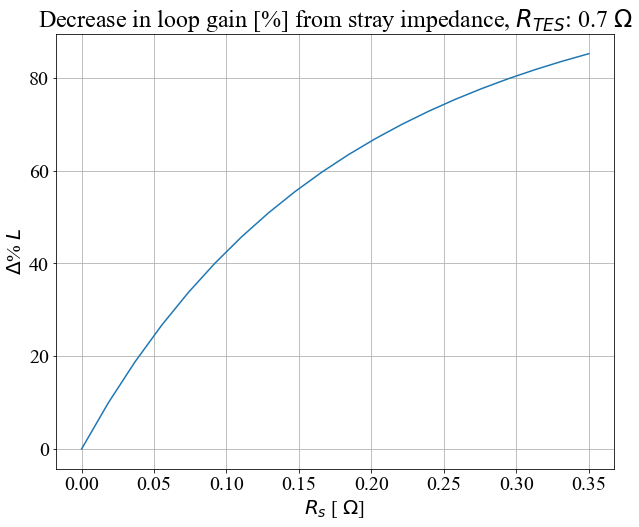

In [13]:
for i in range(0,1):
    # fig = plt.figure(12, figsize=FIG_SIZE)
    # c = plt.pcolormesh( R_s_array, loop_gains, boosts)
    # contour = plt.contour(R_s_array, loop_gains, boosts, colors='black')
    # plt.clabel(contour, inline=True, fontsize=16, fmt='%2.0f')
    # plt.ylabel("Loop gain")
    # plt.xlabel("$R_s$ [ $\\Omega$] ")
    # plt.title("Boost in responsivity [%] from stray impedance, $R_{TES}$: " + str(R_TES) + " $\\Omega$")


    fig = plt.figure(12, figsize=FIG_SIZE)
    c = plt.pcolormesh( R_s_array, loop_gains, boosts_real)
    plt.colorbar(c)
    contour = plt.contour(R_s_array, loop_gains, boosts_real, colors='black')
    plt.clabel(contour, inline=True, fontsize=16, fmt='%2.0f')
    plt.ylabel("Ideal Loop gain")
    plt.xlabel("$R_s$ [ $\\Omega$] ")
    plt.title("Boost in responsivity [%] from stray impedance, $R_{TES}$: " + str(R_TES) + " $\\Omega$")

    loop_gain_decrease = (loop_gains[-1] - loop_gains_real[-1, : ])/loop_gains[-1] * 100
    fig = plt.figure(14, figsize=FIG_SIZE)
    c = plt.plot( R_s_array, loop_gain_decrease)
    plt.ylabel("$\Delta$" +   "% $L$")
    plt.xlabel("$R_s$ [ $\\Omega$] ")
    plt.title("Decrease in loop gain [%] from stray impedance, $R_{TES}$: " + str(R_TES) + " $\\Omega$")
    plt.grid(True)

## What if they are imaginary impedances?

hi
done


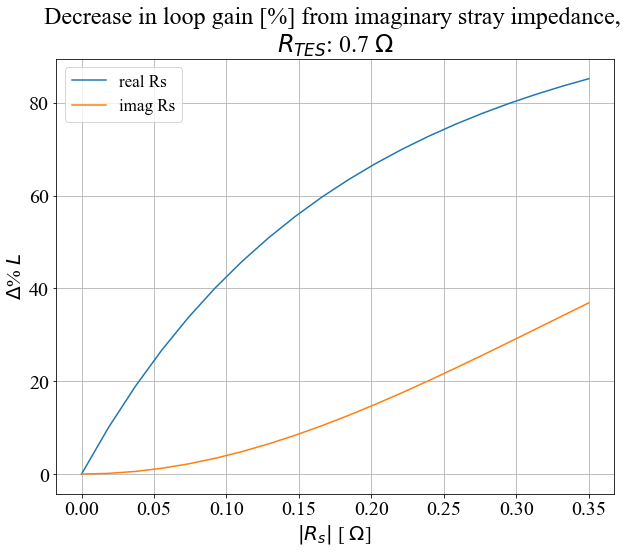

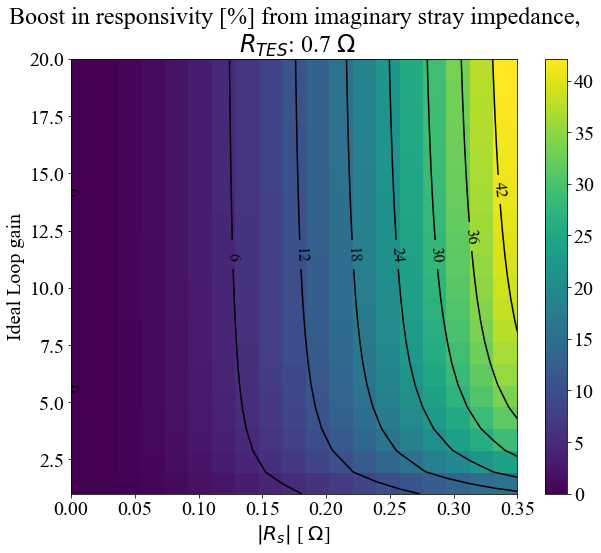

In [18]:
# constants
V_TES_2 = 1 # I won't dial this knob 
R_TES_2 = 1 * 0.7

# initialize arrays to store data
loop_gains_2 = np.linspace(1, 20, 21)
R_s_array_2 = np.linspace(0, R_TES_2/2, 20) *1j

# things we'll evaluate
S_Is_2 = np.zeros( (len(loop_gains_2), len(R_s_array_2)))
S_Is_boosted_2 = np.zeros( (len(loop_gains_2), len(R_s_array_2)))
#boosts_2 = np.zeros( (len(loop_gains), len(R_s_array))) # SI_boosted/SI_not_boosted
boosts_real_2 = np.zeros( (len(loop_gains_2), len(R_s_array_2))) # SI_boosted/SI_not_boosted
loop_gains_real_2 = np.zeros( (len(loop_gains_2), len(R_s_array_2)))
S_Is_real_2 = np.zeros( (len(loop_gains_2), len(R_s_array_2))) # "realistic" , accounting R_s in boost and change in L

for l, loop_gain_2 in enumerate(loop_gains_2):
    for rs, R_s_2 in enumerate(R_s_array_2):
        # adjust Vbias so that V_TES is always the same (should be since V_TES is set by P_OPT)
        V_bias_2 = V_TES_2 *  ( R_TES_2 / (R_TES_2 + R_s_2) ) **(-1)
        
        # calculate responsitivies assuming a fast detector
        # ideal
        #S_I = np.abs( calculate_responsivity(V_TES, loop_gain, tau=None, omega=None)   )
        S_I_2 = S_I_note_74(loop_gain_2, R_TES_2, 0, V_TES_2)
        
        # boosted but with realistic loop gain
        # following equation in LiteBIRD note 74, see what the impact of R_s is on the loopgain
        loop_gain_factor_2 = get_loop_gain_factor(R_TES_2, R_s_2)
        loop_gain_real_2 = loop_gain_2 * loop_gain_factor_2

        #S_I_real = np.abs(calculate_responsivity(V_bias, loop_gain_real, tau=None, omega=None, R_TES=R_TES, R_s = R_s))
        # using Tijmen's equation
        V_TES_2 =  V_bias_2 * R_TES_2 / (R_TES_2 + R_s_2)
        S_I_real_2 = S_I_note_74(loop_gain_real_2, R_TES_2, R_s_2, V_TES_2)
        
        boosts_real_2[l, rs] = (S_I_real_2-S_I_2)/S_I_2 * 100
        
        # store
        S_Is_2[l, rs] = S_I_2
        S_Is_real_2[l, rs] = S_I_real_2
        loop_gains_real_2[l, rs] = loop_gain_real_2
        
    #print(V_TES, R_s, np.conj(R_s), S_I, S_I_real)
        
        #(1-0.05264980633456311j)

        
for i in ([0]):
    loop_gain_decrease_2 = (loop_gains_2[-1] - loop_gains_real_2[-1, : ])/loop_gains_2[-1] * 100
    fig = plt.figure(14, figsize=FIG_SIZE)
    
    c1= plt.plot( np.abs(R_s_array), loop_gain_decrease, label='real Rs')
    c = plt.plot( np.abs(R_s_array_2), loop_gain_decrease_2, label='imag Rs')
    plt.ylabel("$\Delta$" +   "% $L$")
    plt.xlabel("$|R_s|$ [ $\\Omega$] ")
    plt.title("Decrease in loop gain [%] from imaginary stray impedance, \n$R_{TES}$: " + str(R_TES_2) + " $\\Omega$")
    plt.grid(True)
    plt.legend()
    print("hi")

for i in ([0]):
    fig = plt.figure(12, figsize=FIG_SIZE)
    c = plt.pcolormesh( np.abs(R_s_array_2), loop_gains_2, boosts_real_2)
    plt.colorbar(c)
    contour = plt.contour(np.abs(R_s_array_2), loop_gains_2, boosts_real_2, colors='black')
    plt.clabel(contour, inline=True, fontsize=16, fmt='%2.0f')
    plt.ylabel("Ideal Loop gain")
    plt.xlabel("$|R_s|$ [ $\\Omega$] ")
    plt.title("Boost in responsivity [%] from imaginary stray impedance,\n $R_{TES}$: " + str(R_TES_2) + " $\\Omega$")
    print("done")

### Simulating PB2b Loop gain degradation

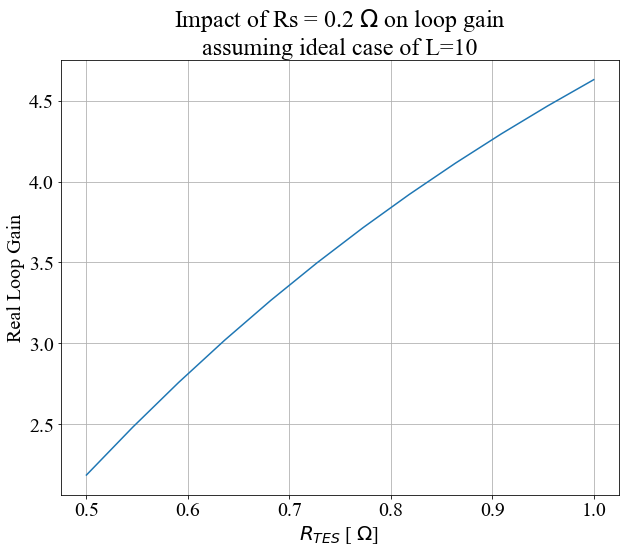

In [15]:

R_TESs = np.linspace(0.5, 1, 12)
R_s = 0.2
loop_gain = 10

# data to collect
loop_gains_real = np.zeros(len(R_TESs))

for rc, R_TES in enumerate(R_TESs):
    
    loop_gains_real[rc] = loop_gain * get_loop_gain_factor(R_TES, R_s)
    

plt.figure(15, figsize=FIG_SIZE)
plt.plot( R_TESs, loop_gains_real)
plt.ylabel("Real Loop Gain")
plt.xlabel("$R_{TES}$ [ $\\Omega$] ")
plt.title("Impact of Rs = " + str(R_s) +" $\\Omega$ on loop gain \nassuming ideal case of L=10")
plt.grid(True)